### We first start with a dummy ridge regressor that scored a RMSE of 167.1334 on the kaggle competition

In [163]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
airtrain = pd.get_dummies(airtrain,columns=['Gas'])


airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest = pd.get_dummies(airtest,columns=['Gas'])


X = airtrain.drop(['Value'],axis=1)
y = airtrain['Value']
model.fit(X, y)
predictions=model.predict(airtest)
predictions=pd.DataFrame(predictions)
predictions
predictions.to_csv('./predictions/1st_predictions.csv')




In [164]:
airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest.to_csv('./predictions/test.csv')

<AxesSubplot:>

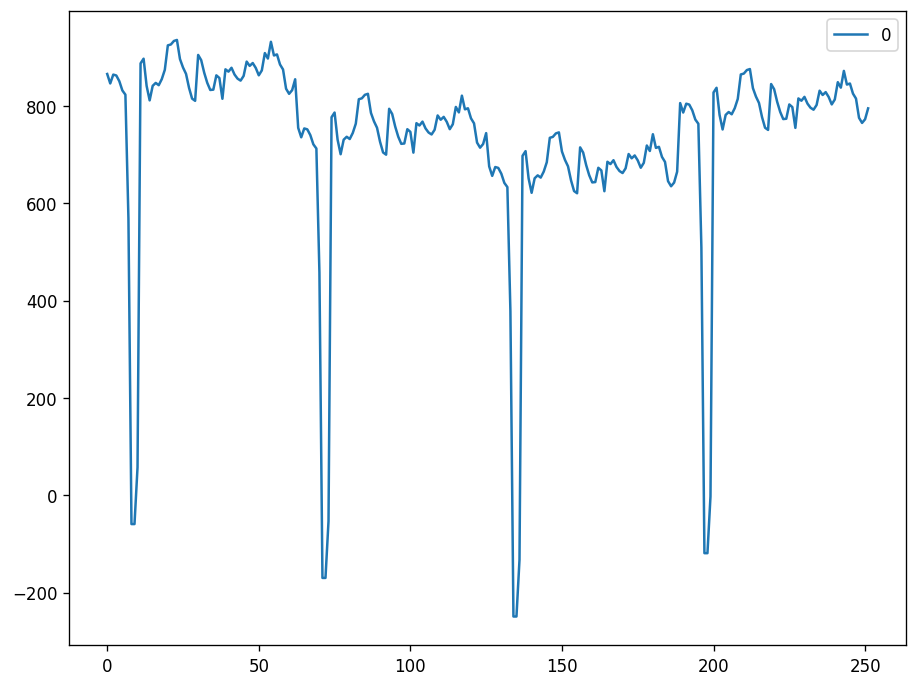

In [165]:
predictions.plot()

# Exploratory Data Analysis

In [166]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           1312 non-null   float64
 1   RH          1312 non-null   float64
 2   Gas         1312 non-null   object 
 3   Value       1312 non-null   float64
 4   Unnamed: 5  0 non-null      float64
 5   Unnamed: 6  0 non-null      float64
dtypes: float64(5), object(1)
memory usage: 71.8+ KB


### Looks like there are various types of Gases 

In [167]:
# show 5 random rows of dataframe 
# drop column index 5 and 6 dataframe
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

airtrain.sample(5)

,T,RH,Gas,Value
Date,,,,
2016-07-15,26.618056,35.734722,NO2,754.138889
2017-01-22,6.660069,46.915278,CO,896.744444
2016-07-01,28.094792,32.237500,NO2,730.691667
2016-04-01,12.585417,46.546875,HC,698.391667
2016-03-22,18.772917,41.165625,CO,1090.166667


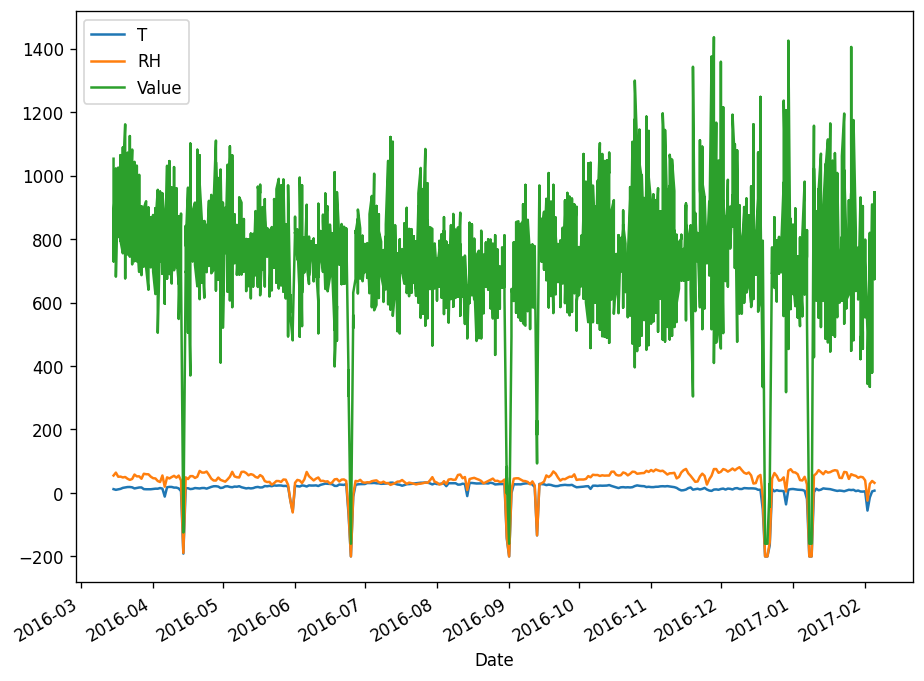

In [168]:
airtrain.plot()
plt.show()

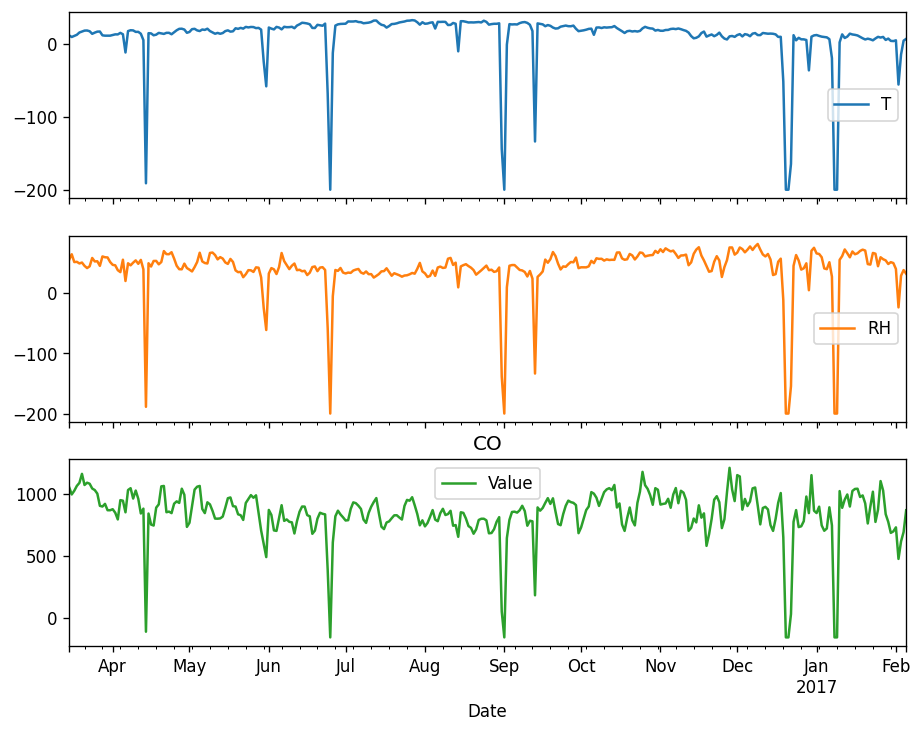

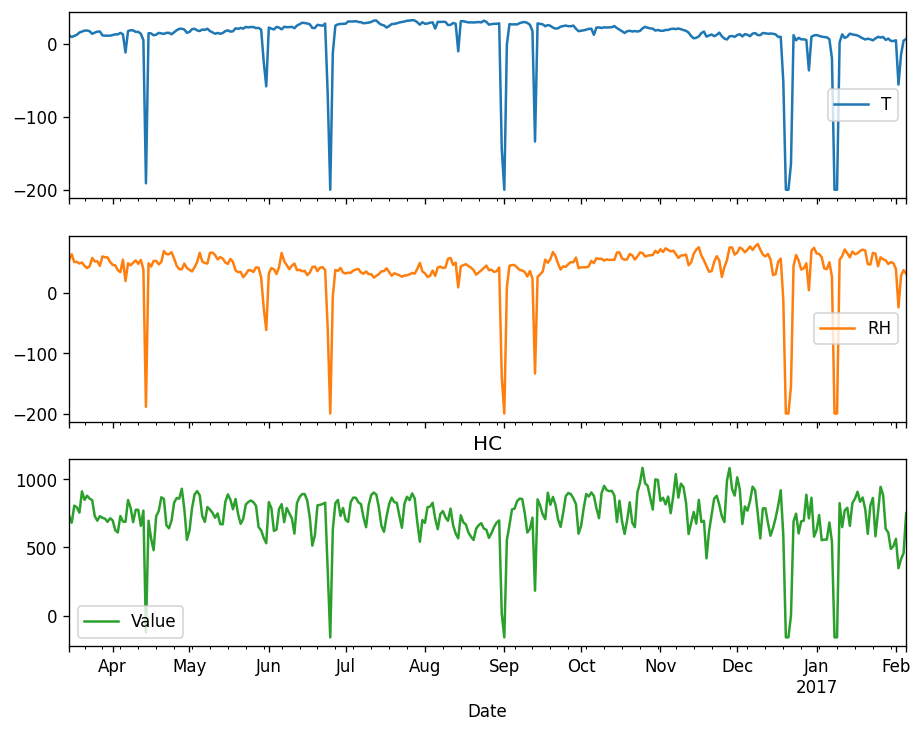

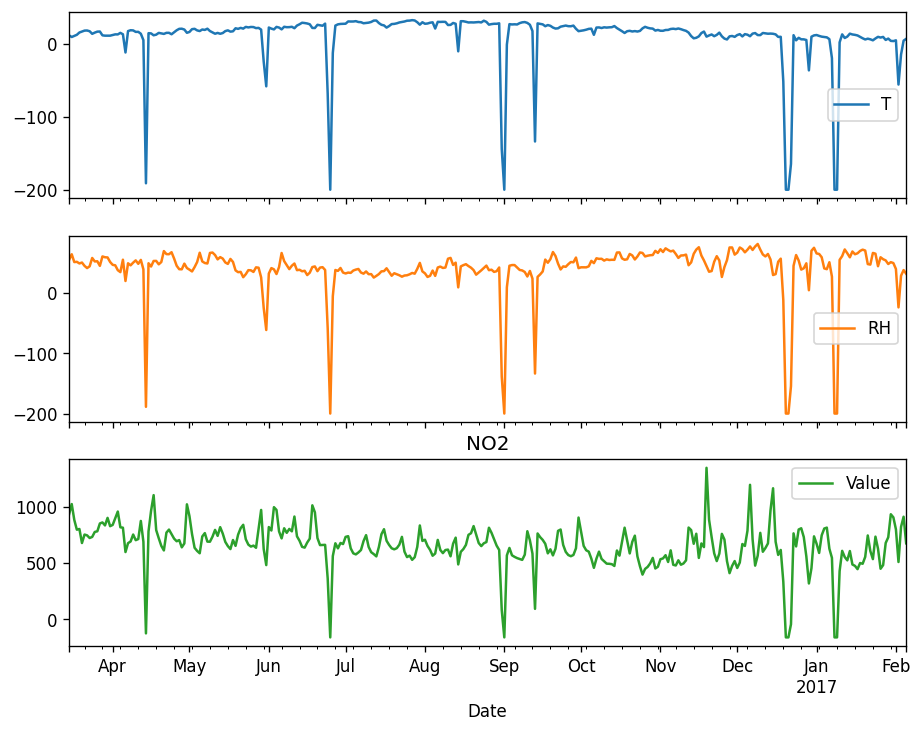

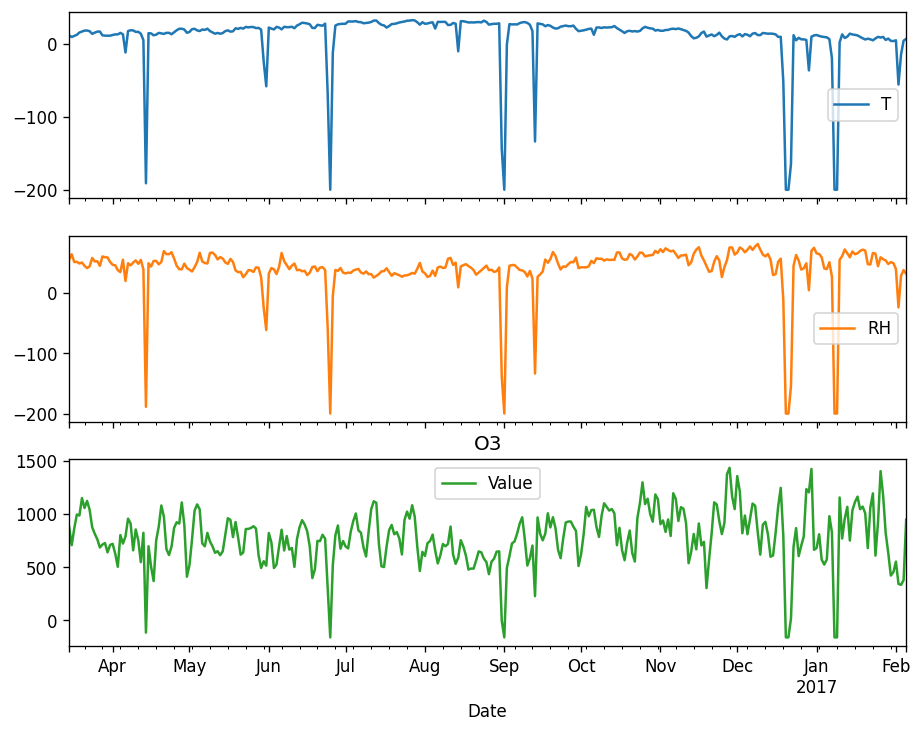

In [169]:
#plot a graph group by the Gas column with label as the Gas column
gases=airtrain.Gas.unique() #['CO' 'HC' 'NO2' 'O3']
# use a loop to filter out the gas column with the array gases

for gas in gases:
    airtrain[airtrain.Gas==gas].plot(subplots=True)
    #set title as gas at the top of each plot 
    plt.title(gas)
    plt.show()

### The attributes T, RH and Value are dropping below zero at certain points.  
There seems to be no missing values but 31 data points dropping below 0 which shouldn't be possible



In [170]:
print(airtrain.info())
airtrain[airtrain['Value']<0].count()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1312 non-null   float64
 1   RH      1312 non-null   float64
 2   Gas     1312 non-null   object 
 3   Value   1312 non-null   float64
dtypes: float64(3), object(1)
memory usage: 51.2+ KB
None


T        31
RH       31
Gas      31
Value    31
dtype: int64

### We can safely assume that when T or RH is -200 , Value will always be -200

In [171]:
#np.logical_or in list comprehension of airtrain
print('Times when T or RH is -200 and Value is not -160',airtrain[((airtrain['T']==-200) | (airtrain["RH"] ==-200)) & (airtrain['Value']!=-160)].count())

#This just shows that when T or RH is -200 and Value is always -160

Times when T or RH is -200 and Value is not -160 T        0
RH       0
Gas      0
Value    0
dtype: int64


### Looks like the dataset is also normally distributed for each of its attributes

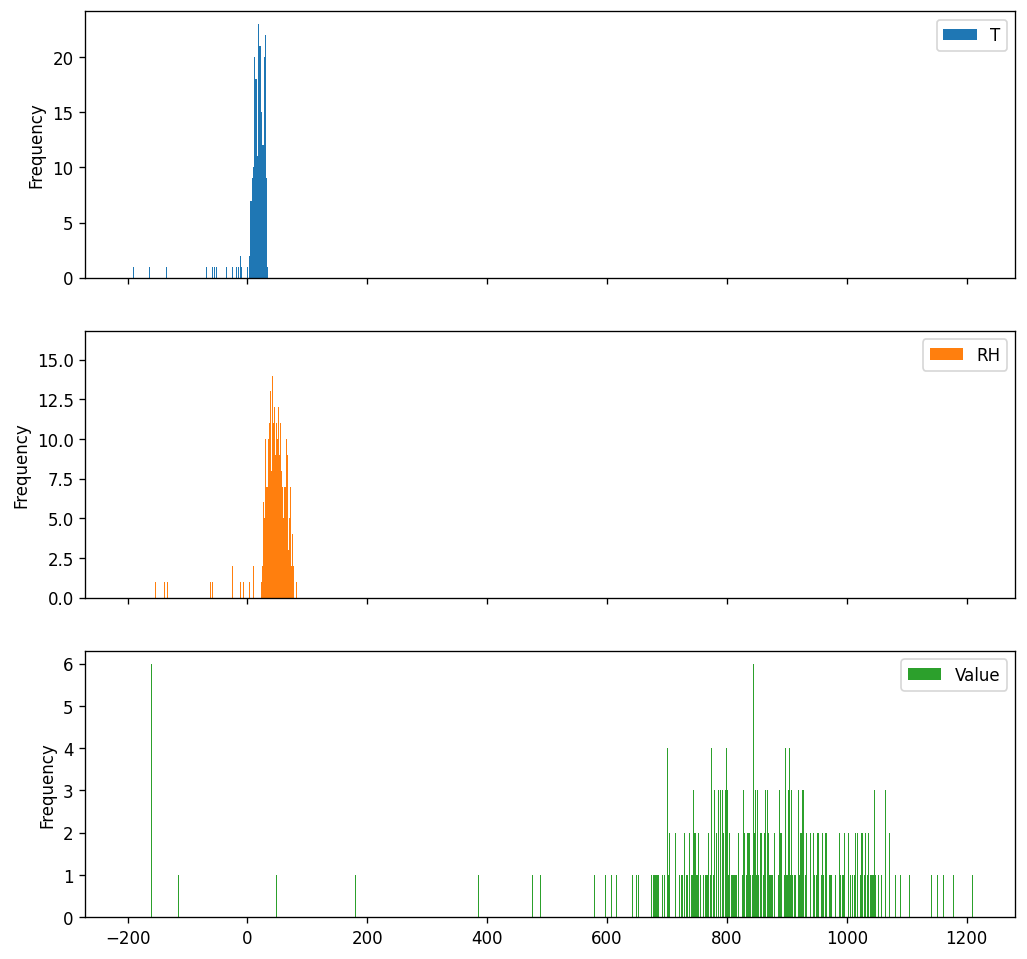

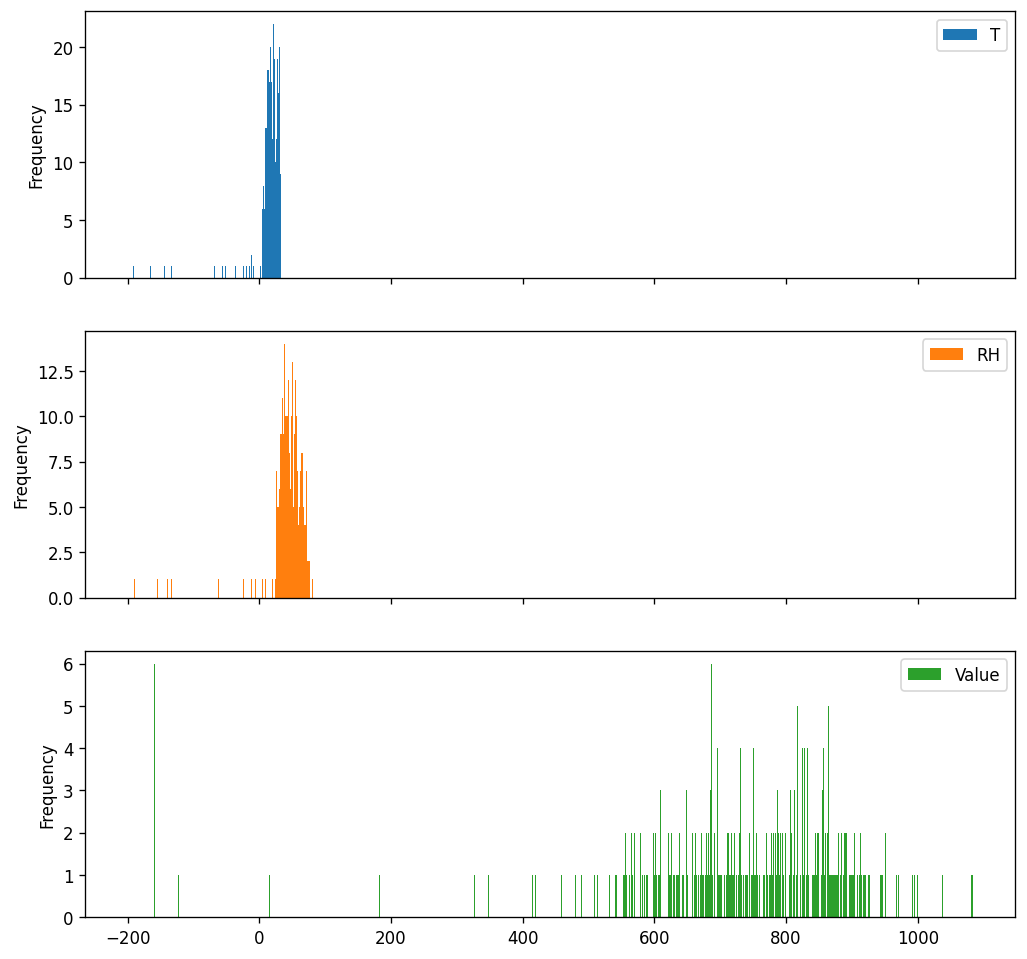

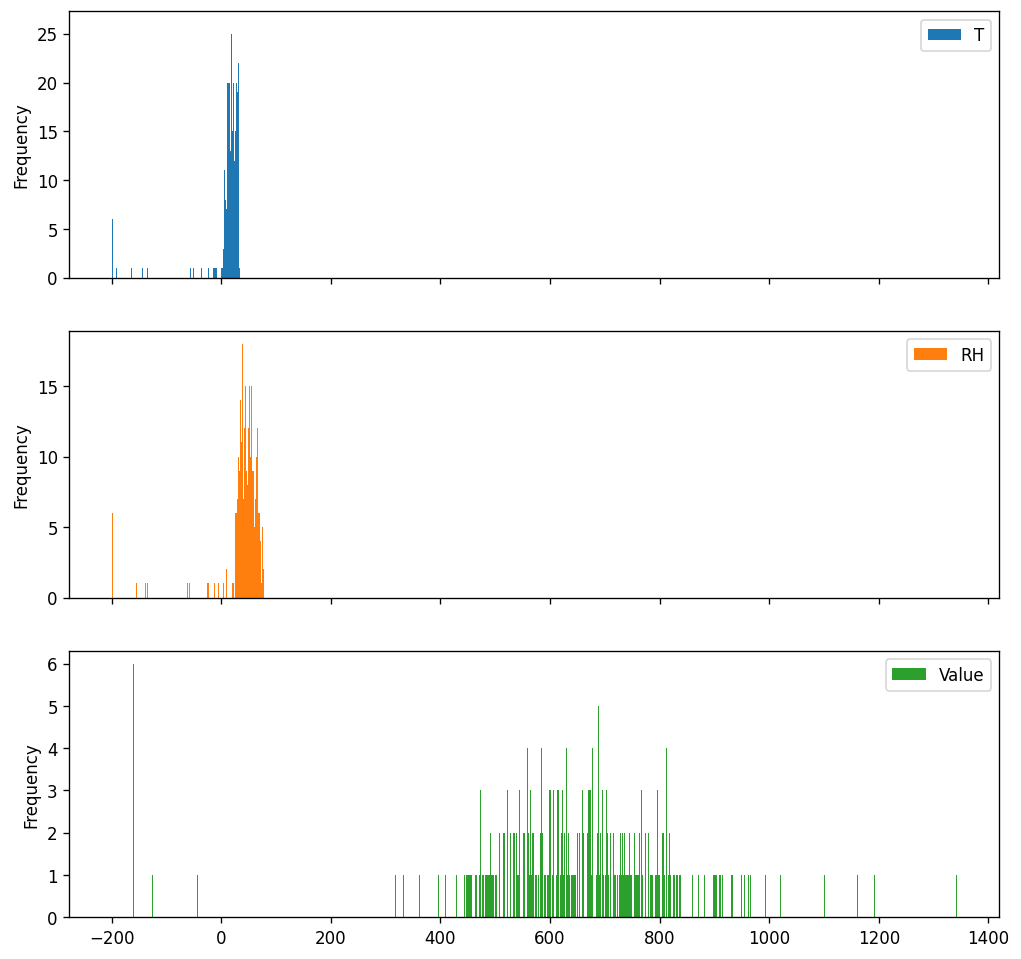

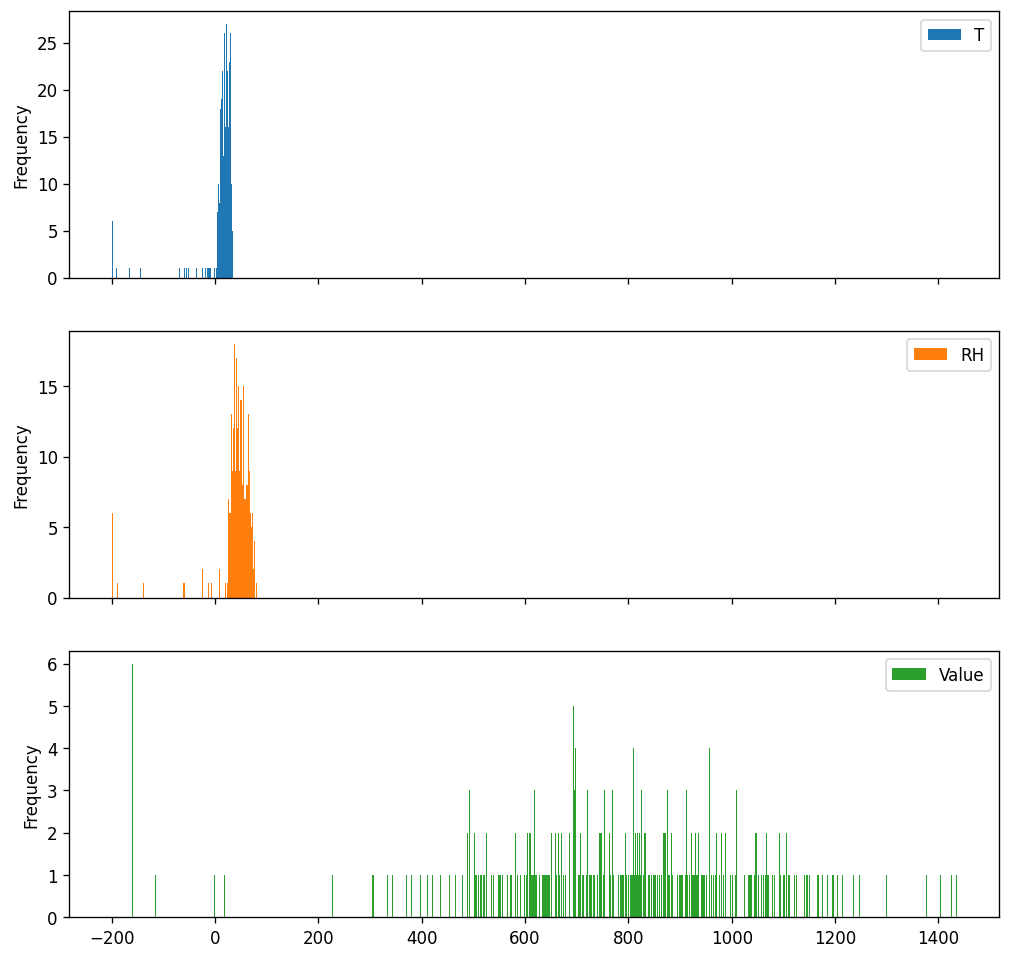

In [172]:
# plot a graph group by the Gas column with label as the Gas column
airtrain.groupby('Gas').plot(kind='hist',subplots=True,figsize=(10,10),bins = 1000)
plt.show()

### Stationarity test
[stationarity test]https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/  

We will perform both augmented dickey fuller(Adfuller) test and a Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test  
to find out whether the dataset has a unit root

In [173]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
result3 = adfuller(airtrain.Value)
print('number of observations:',result3[3],'\nAir Dataset Value attribute p-value: %f' % result3[1])

number of observations: 1288 
Air Dataset Value attribute p-value: 0.000039


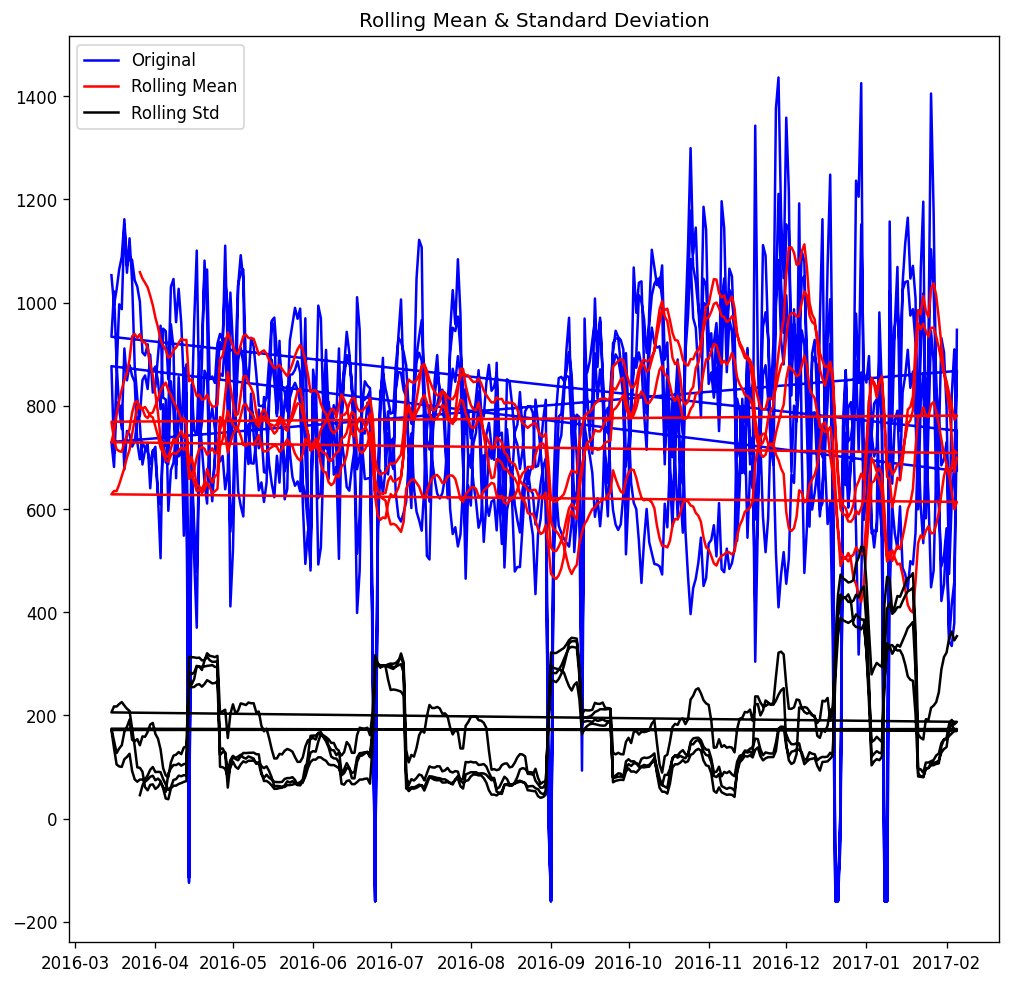

Results of Dickey-Fuller Test:
Test Statistic                   -4.874493
p-value                           0.000039
#Lags Used                       23.000000
Number of Observations Used    1288.000000
Critical Value (1%)              -3.435437
Critical Value (5%)              -2.863787
Critical Value (10%)             -2.567966
dtype: float64
Strong evidence to reject the null hypothesis, the series is stationary


In [174]:
#test for stationarity in airtrain dataframe
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=[10,10])
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # check if the p-value is less than 0.05, if yes, then we can reject the null hypothesis that the data is stationary
    if dftest[1] < 0.05:
        print('Strong evidence to reject the null hypothesis, the series is stationary')
    else:
        print('Weak evidence to reject the null hypothesis, the series is non-stationary')
        
    plt.show()

test_stationarity(airtrain.Value)

In [175]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
kpss_test(airtrain.Value,regression='c')

KPSS Statistic: 1.2249555213186396
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Differencing will be done as recommended by Statsmodels.org  
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html  

Case 1: Both tests conclude that the series is not stationary - The series is not stationary  

Case 2: Both tests conclude that the series is stationary - The series is stationary  

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.  

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.



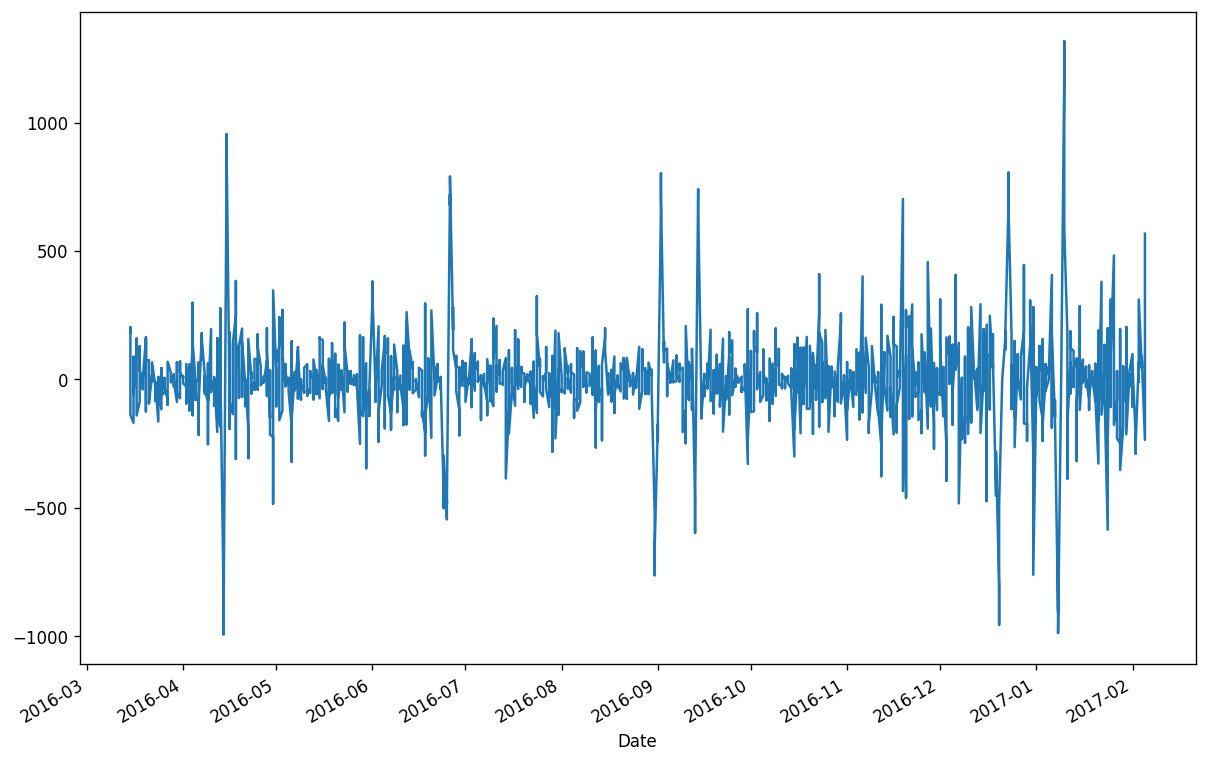

In [176]:
airtrain["Value_diff"] = airtrain["Value"] - airtrain["Value"].shift(1)
airtrain["Value_diff"].dropna().plot(figsize=(12, 8))
plt.show()

In [177]:

airtrain['Value_diff']=airtrain['Value_diff'].fillna(airtrain['Value_diff'].mean())

### Great looks like it is stationary now

In [178]:
kpss_test(airtrain["Value_diff"], regression='c')

KPSS Statistic: 0.1574061051571555
p-value: 0.1
num lags: 187
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


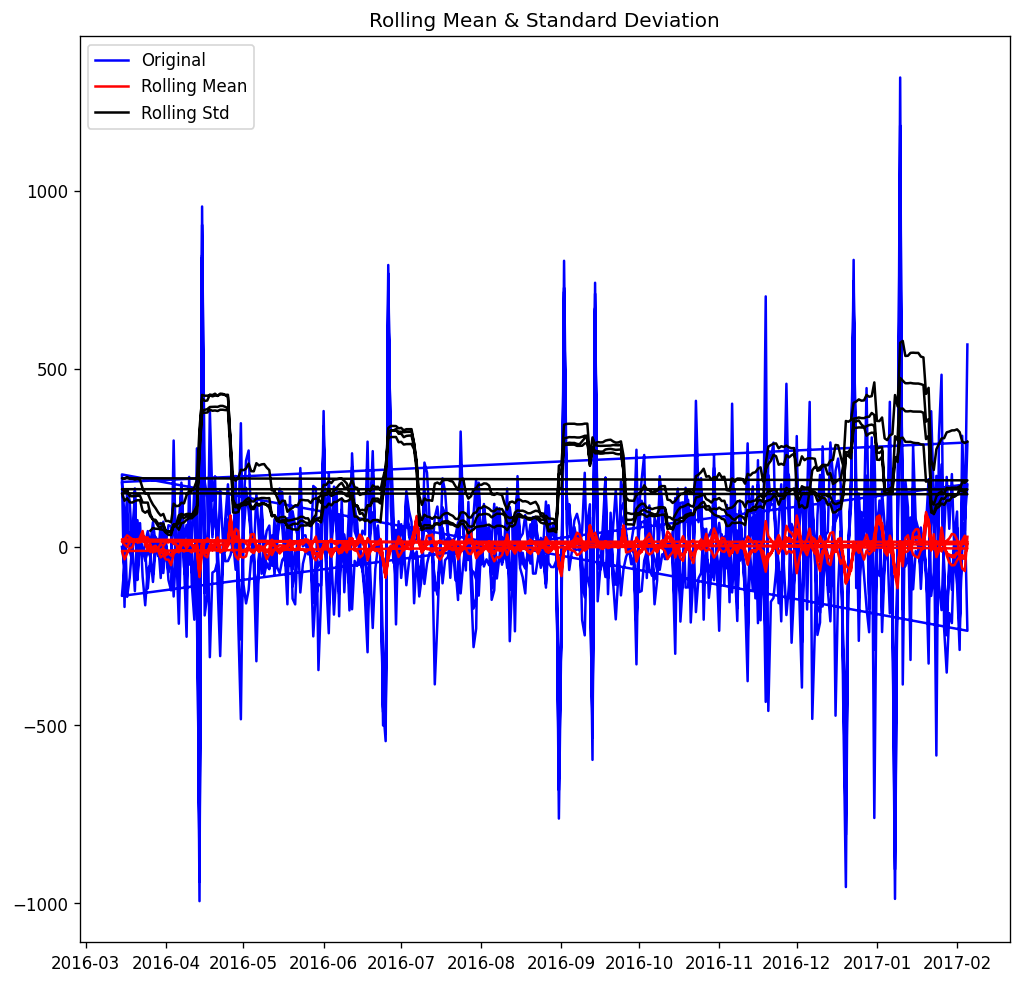

Results of Dickey-Fuller Test:
Test Statistic                -1.150443e+01
p-value                        4.411004e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.288000e+03
Critical Value (1%)           -3.435437e+00
Critical Value (5%)           -2.863787e+00
Critical Value (10%)          -2.567966e+00
dtype: float64
Strong evidence to reject the null hypothesis, the series is stationary


In [179]:
test_stationarity(airtrain["Value_diff"])

In [180]:
airtrain

,T,RH,Gas,Value,Value_diff
Date,,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000,-0.080753
2016-03-16,9.833333,64.069791,CO,995.250000,-57.950000
2016-03-17,11.292708,51.107292,CO,1025.250000,30.000000
2016-03-18,12.866319,51.530903,CO,1064.444444,39.194444
2016-03-19,16.016667,48.843750,CO,1088.741667,24.297223
...,...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556,99.022222
2017-02-02,-55.515972,-24.010417,O3,343.500000,-209.680556
2017-02-03,-14.272917,28.563542,O3,334.458333,-9.041667


# Feature Engineering
## Firstly we pivot the dataset for a better overview 

In [181]:
# pivot table
data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
temp = pd.DataFrame(data['T'].groupby(['Date']).mean())
rh = pd.DataFrame(data['RH'].groupby(['Date']).mean())
pivot = pd.pivot(data, columns = 'Gas', values = 'Value')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
df

,T,RH,CO_Value,HC_Value,NO2_Value,O3_Value
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


### Correlation test using pivoted data

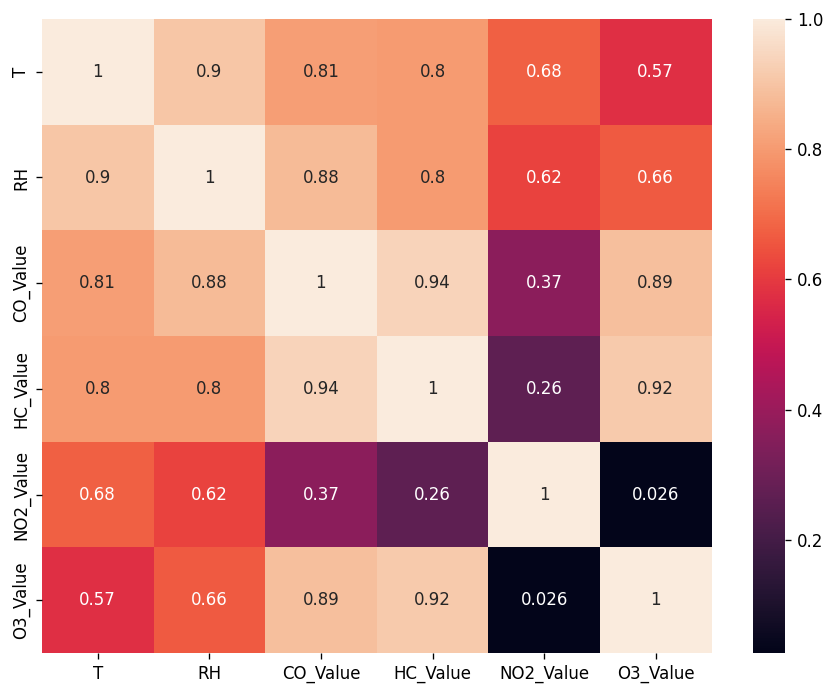

In [182]:
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

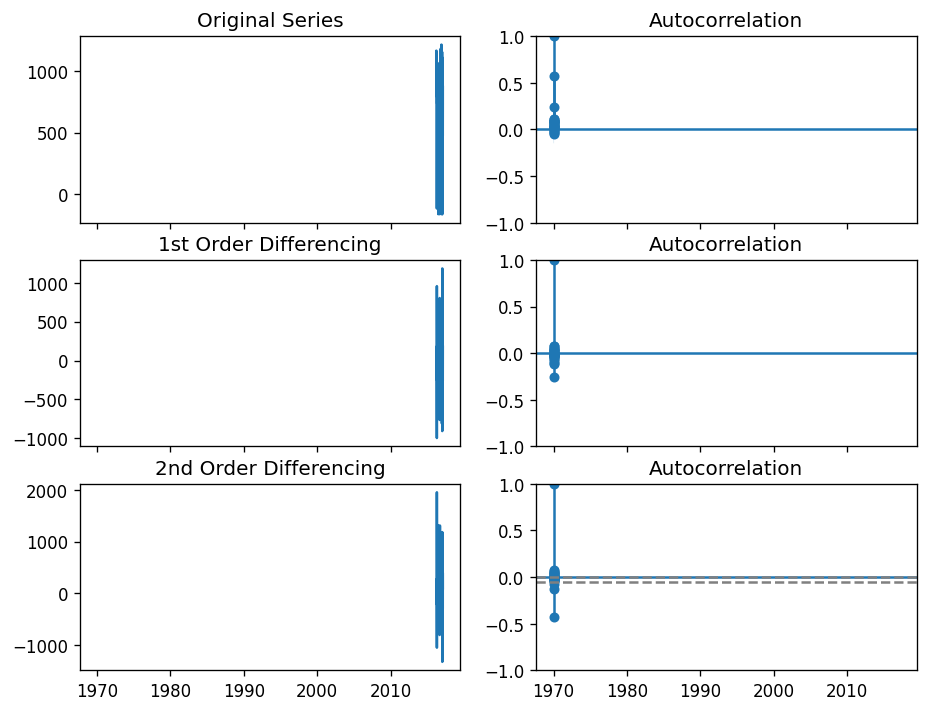

In [183]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7)})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.CO_Value); axes[0, 0].set_title('Original Series')
plot_acf(df.CO_Value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.CO_Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.CO_Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.CO_Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.CO_Value.diff().diff().dropna(), ax=axes[2, 1])
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airtrain.Value)),linestyle='--',color='gray')
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


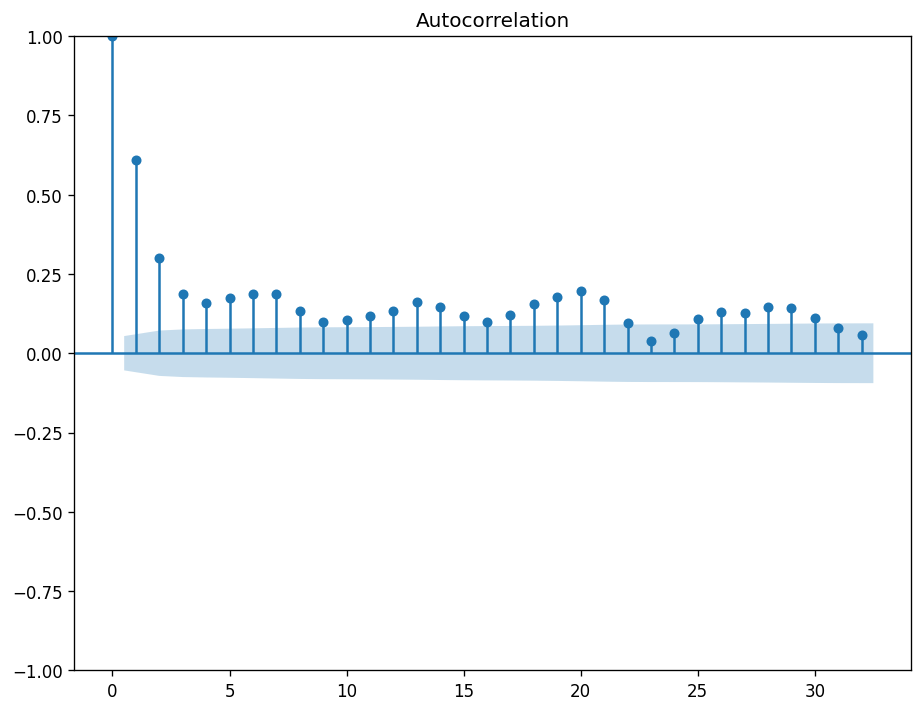

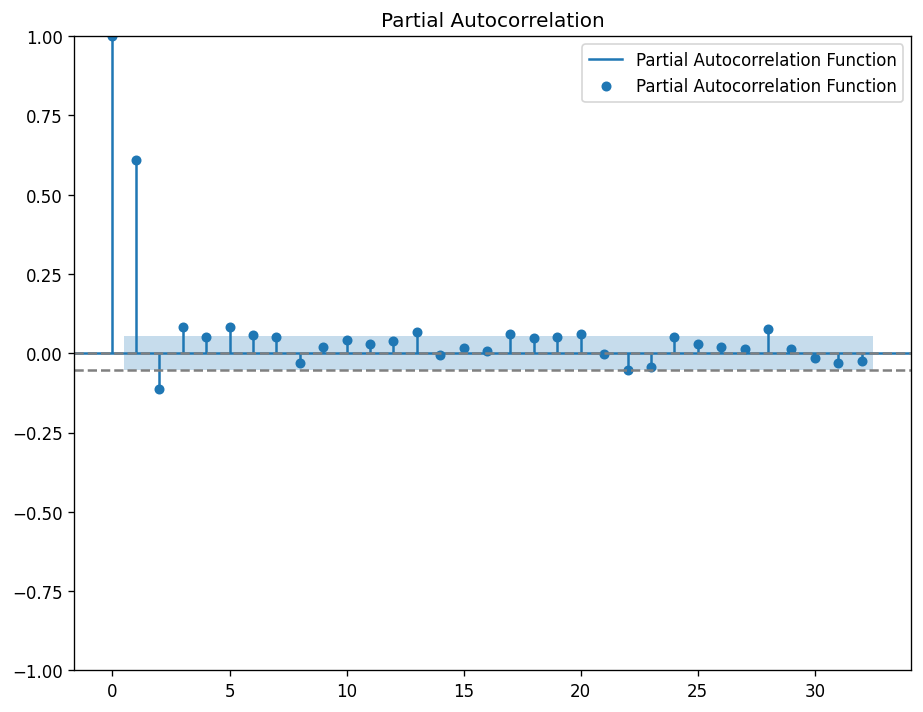

In [184]:
#autocorrelation of airtrain dataframe

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# lag_acf = acf(airtrain.Value, nlags=365)
# lag_pacf = pacf(airtrain.Value, nlags=365, method='ols')
#Plot ACF:
plot_acf(airtrain['Value'],label='Autocorrelation Function')
plot_pacf(airtrain['Value'],label='Partial Autocorrelation Function')
# plt.plot(lag_acf,label='Autocorrelation Function')
# plt.plot(lag_pacf, label='Partial Autocorrelation Function')
plt.legend()
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airtrain.Value)),linestyle='--',color='gray')

## Value is normally distributed , adfuller and dickey-fuller result < 0.05 thus stationary

- Consistency of Mean
- Consistency of Standard Deviation
- Consistency of Auto correlation 

* Auto correlation is not very close to zero so its still possible to predict based on past data

In [185]:
# I will be transforming the data into Lets make asfreq to day and make got sure got no null
# Another way of cleaning is for each date u have the following columns:
# T_CO ,RH_CO, Value_CO, 
# T_HC ,RH_HC, Value_HC, 
# T_NO2 ,RH_NO2, Value_NO2, 
# T_O3 ,RH_O3, Value_O3 
TrainTransform = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
TrainTransform.drop(TrainTransform.columns[4:6],axis=1,inplace=True)
CO = TrainTransform[TrainTransform.Gas=='CO']
CO = pd.DataFrame(CO)
CO.index = CO.index.to_period('D')
CO.sort_index(inplace=True)
CO.drop(['Gas'],axis=1,inplace=True)
CO=CO.rename(columns={"Value":"Value_CO"})


HC = TrainTransform[TrainTransform.Gas=='HC']
HC = pd.DataFrame(HC)
HC.index = HC.index.to_period('D')
HC.sort_index(inplace=True)
HC.drop(['Gas','T','RH'],axis=1,inplace=True)
HC=HC.rename(columns={"Value":"Value_HC"})



NO2 = TrainTransform[TrainTransform.Gas=='NO2']
NO2 = pd.DataFrame(NO2)
NO2.index = NO2.index.to_period('D')
NO2.sort_index(inplace=True)
NO2.drop(['Gas','T','RH'],axis=1,inplace=True)
NO2=NO2.rename(columns={"Value":"Value_NO2"})

O3 = TrainTransform[TrainTransform.Gas=='O3']
O3 = pd.DataFrame(O3)
O3.index = O3.index.to_period('D')
O3.sort_index(inplace=True)
O3.drop(['Gas','T','RH'],axis=1,inplace=True)
O3=O3.rename(columns={"Value":"Value_O3"})

traintransformed = pd.concat([CO, HC, NO2, O3], axis=1)
traintransformed
# corr = traintransformed.corr()
# sns.heatmap(corr, annot=True)
# plt.show()


,T,RH,Value_CO,Value_HC,Value_NO2,Value_O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


In [186]:
traintransformed

,T,RH,Value_CO,Value_HC,Value_NO2,Value_O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


### Seasonal decomposition

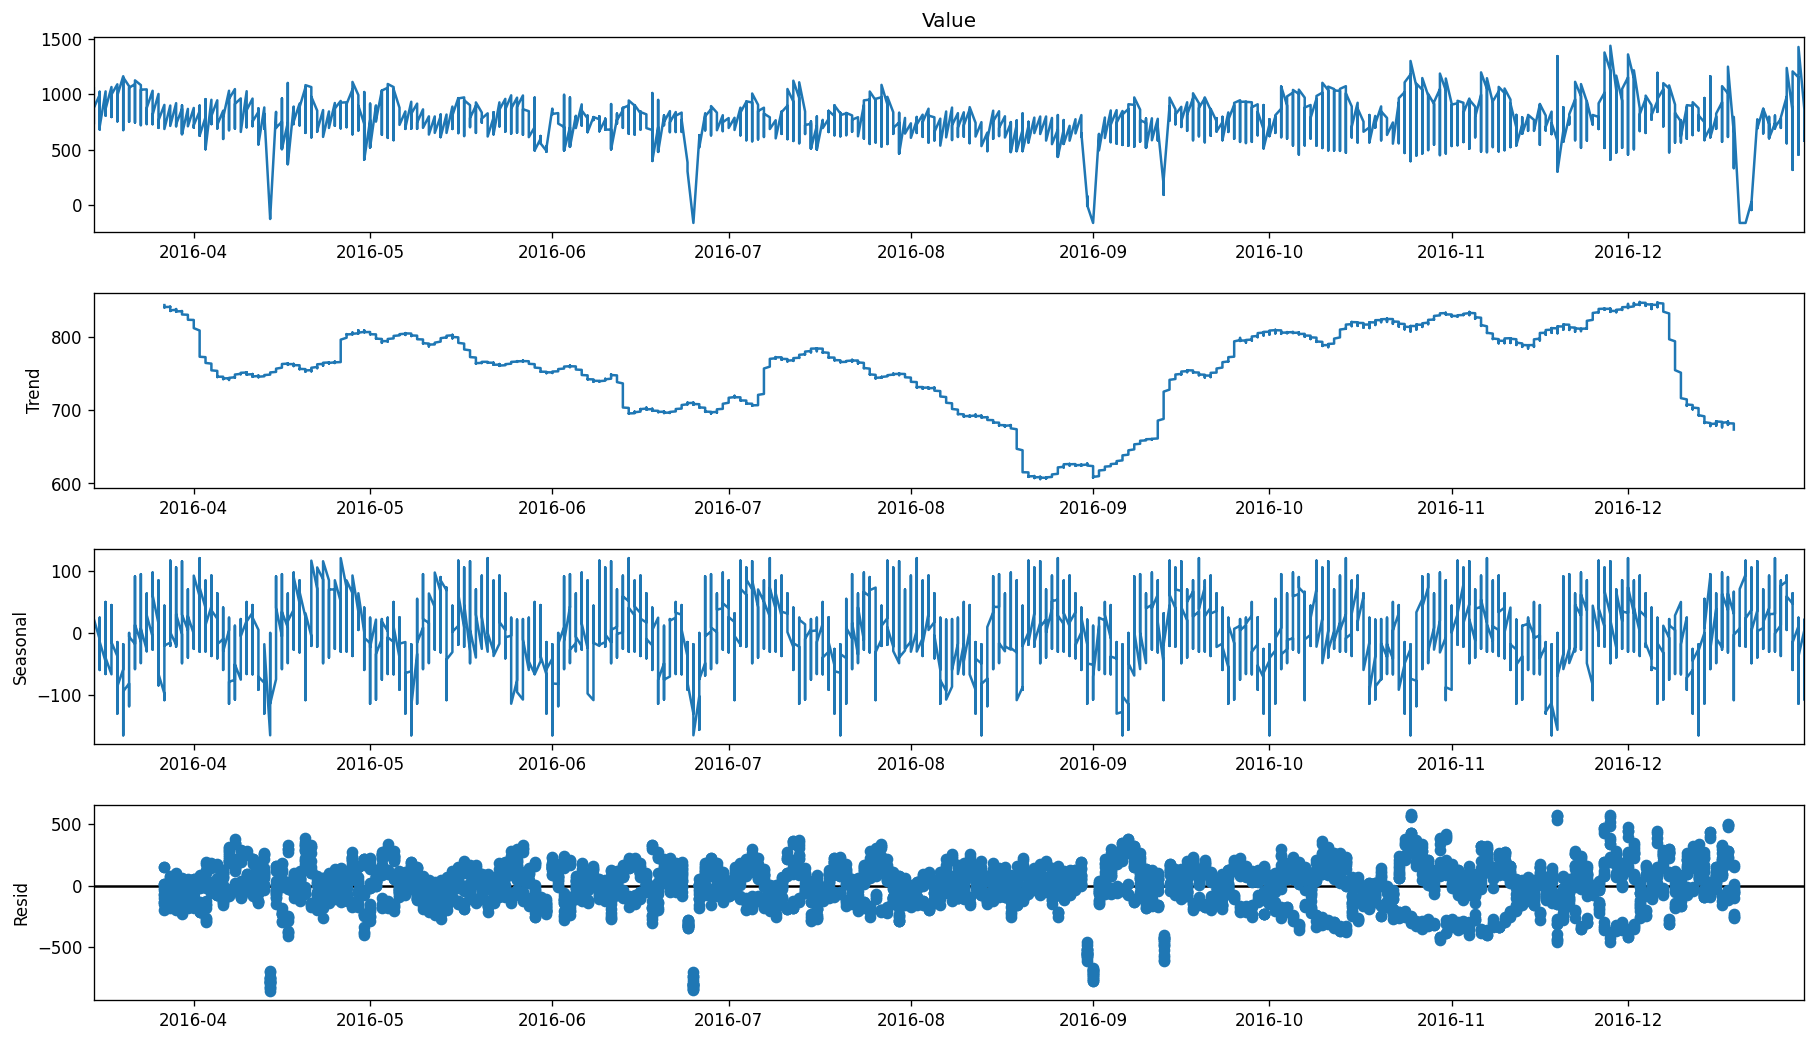

In [187]:
#Timeseries decomposition on airtrain data
from statsmodels.tsa.seasonal import seasonal_decompose
time_decompose = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

time_decompose.drop(time_decompose.columns[4:6],axis=1,inplace=True)

dummy = pd.get_dummies(time_decompose['Gas'])
# Join the encoded df
time_decompose = time_decompose.join(dummy)
time_decompose = time_decompose.drop('Gas',axis = 1)

# only take 2016 
time_decompose=time_decompose.loc['2016']
time_decompose.sort_index()
decompose_result_mult = seasonal_decompose(time_decompose['Value'], model="additive",period = int(len(time_decompose['Value'])/12))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()




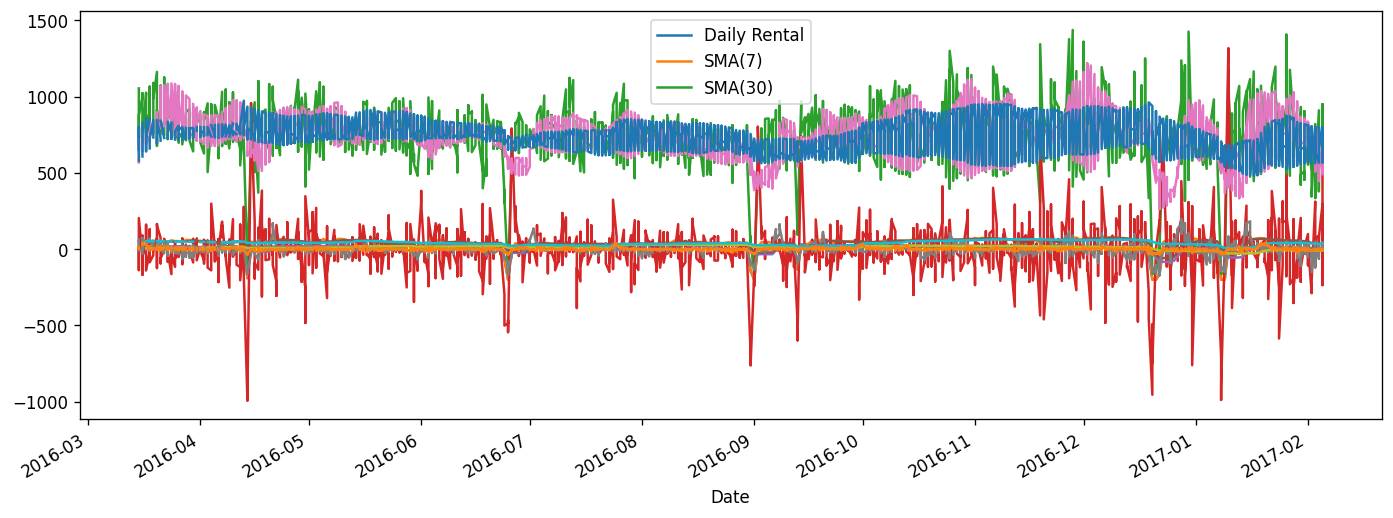

In [188]:
# rolling 
daily_rental = airtrain
ax = daily_rental.plot(figsize=(14, 5))
daily_rental.rolling(window=7).mean().plot(ax=ax)
daily_rental.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Daily Rental', 'SMA(7)', 'SMA(30)'])
plt.show()

In [189]:
# pip install statsmodels

# TimeSeries Models

## Holts Winter Exponential Smoothing Function

In [190]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
CO = airtrain[airtrain.Gas=='CO'].drop(['Gas'],axis=1).Value
HC = airtrain[airtrain.Gas=='HC'].drop(['Gas'],axis=1).Value
NO2 = airtrain[airtrain.Gas=='NO2'].drop(['Gas'],axis=1).Value
O3 = airtrain[airtrain.Gas=='O3'].drop(['Gas'],axis=1).Value


airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)

airtest.drop(['id'],axis=1,inplace=True)



In [191]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
CO_model = HWES(CO, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
CO_pred = CO_model.predict(start='2017-02-06', end='2017-04-10')

HC_model = HWES(HC, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
HC_pred = HC_model.predict(start='2017-02-06', end='2017-04-10')


NO2_model = HWES(NO2, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
N02_pred = NO2_model.predict(start='2017-02-06', end='2017-04-10')

O3_model = HWES(O3, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
O3_pred = O3_model.predict(start='2017-02-06', end='2017-04-10')


In [192]:
#drop first column of CO_pred 
CO_pred = CO_pred.drop(CO_pred.index[0])
HC_pred = HC_pred.drop(HC_pred.index[0])
N02_pred = N02_pred.drop(N02_pred.index[0])
O3_pred = O3_pred.drop(O3_pred.index[0])

#concatenate CO_pred, HC_pred, N02_pred, O3_pred
pred = pd.concat([CO_pred, HC_pred, N02_pred, O3_pred], axis=0)
#create index 0 to len(pred)
pred.index = range(len(pred))

pred.to_csv('./predictions/pred.csv')


In [193]:
# Code a function in which it tests how good a model is by comparing the actual values to the predicted values
def test_model(model, X, y):
    from sklearn.metrics import mean_absolute_percentage_error
    pred = model.predict(X)
    mape = mean_absolute_percentage_error(y, pred)
    return mape

In [194]:

def convert_cheat(dataframe):
    #if index of y_pred is in (id) then y_pred value is -200
    extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
    extract200.drop(extract200.columns[3:],axis=1,inplace=True)
    #extract the id column of extract200 where "T" or "RH" == -200
    ids=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
    ids=list(ids)
    df = pd.read_csv(dataframe)
    for x in ids:
        df.loc[df['id']==x,'Value'] = -160
    df.to_csv('./train.csvpredictions/predictions_fixed.csv',index=False)
    return 0

## Auto Regressive Integrated Moving Average (ARIMA)

,T,RH,CO_Value,HC_Value,NO2_Value,O3_Value
Date,,,,,,
2016-03-15,12.020833,54.883334,750.218839,-137.800000,181.966667,203.091667
2016-03-16,9.833333,64.069791,-57.950000,-48.358333,87.950000,-168.808333
2016-03-17,11.292708,51.107292,30.000000,125.141667,-140.375000,159.350000
2016-03-18,12.866319,51.530903,39.194444,-12.325000,-86.847222,129.250000
2016-03-19,16.016667,48.843750,24.297223,-39.175000,6.355556,-9.283333
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,32.655555,53.791667,-106.269444,99.022222
2017-02-02,-55.515972,-24.010417,-255.130555,-215.169444,-289.466667,-209.680556
2017-02-03,-14.272917,28.563542,141.408333,66.994444,311.552778,-9.041667


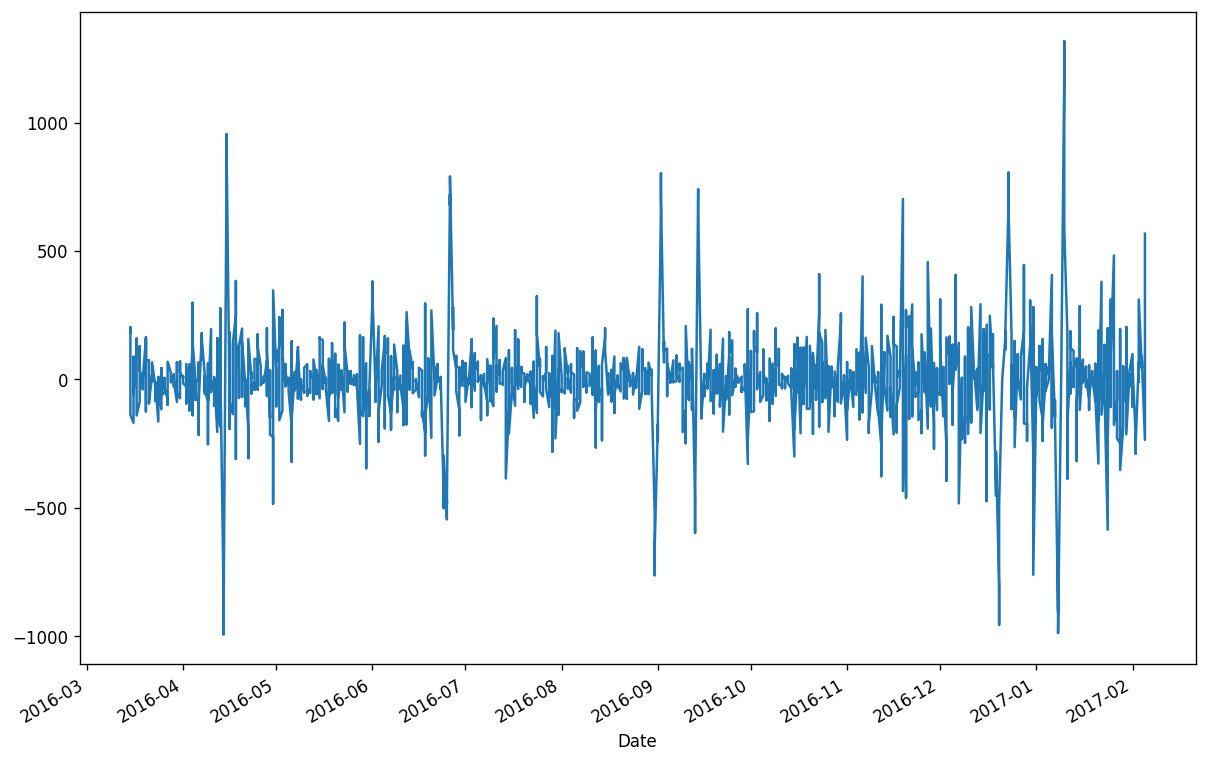

In [195]:
# import data
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain["Value_diff"] = airtrain["Value"] - airtrain["Value"].shift(1)
airtrain["Value_diff"].dropna().plot(figsize=(12, 8))
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
airtrain['Value_diff']=airtrain['Value_diff'].fillna(airtrain['Value'].mean())






# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
airtrain.drop('Value',axis=1,inplace=True)
temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value_diff')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
df

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               CO_Value   No. Observations:                  328
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -2194.356
Date:                Fri, 05 Aug 2022   AIC                           4404.712
Time:                        22:10:15   BIC                           4435.032
Sample:                    03-15-2016   HQIC                          4416.810
                         - 02-05-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990      0.033    -30.084      0.000      -1.064      -0.934
ar.L2         -1.0962      0.052    -21.120      0.000      -1.198      -0.994
ar.L3         -1.0193      0.069    -14.772      0.0

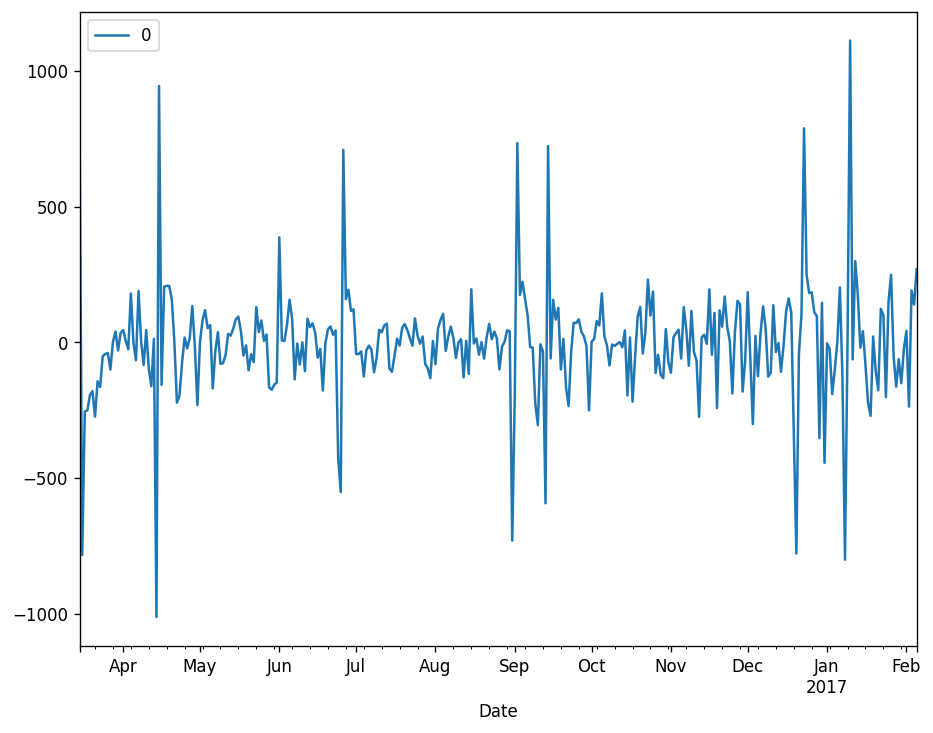

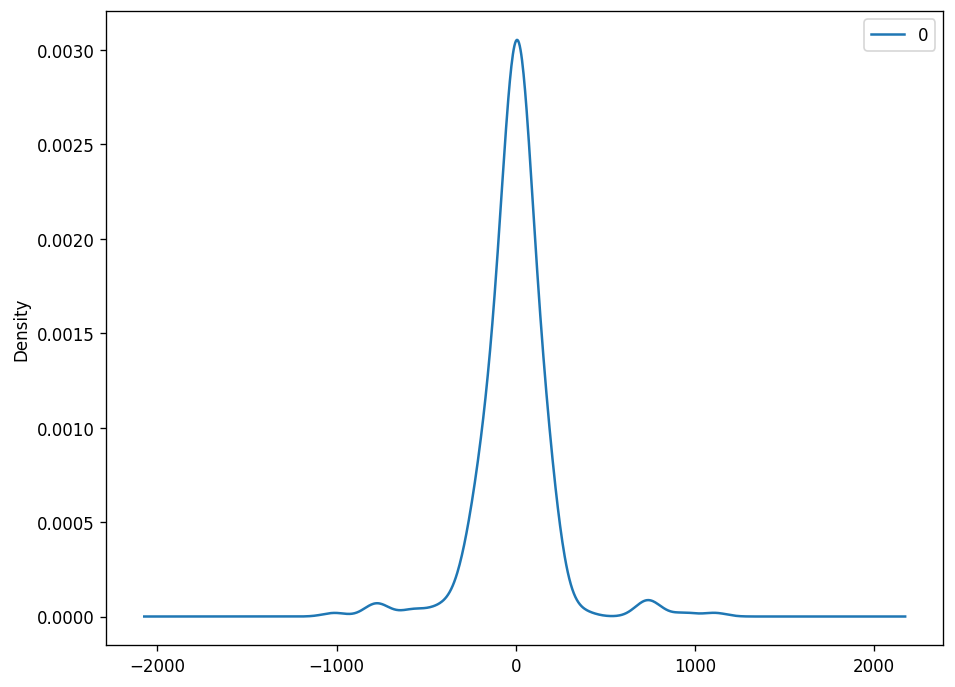

                 0
count   328.000000
mean     -4.237092
std     205.130555
min   -1011.698950
25%     -79.508779
50%       2.078444
75%      68.499667
max    1112.178404


In [196]:
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df['CO_Value'], order=(7,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())